# Project: Yes/No Question Answering with BoolQ Dataset

## Introduction

This project is an implementation of a yes/no question-answering system using the [BoolQ dataset](https://dl.fbaipublicfiles.com/glue/superglue/data/v2/BoolQ.zip) from the SuperGLUE benchmark. BoolQ is a dataset designed for yes/no questions, where each sample contains a question, a passage providing context, and the correct answer (yes or no).

The goal of this project is to explore different models and techniques to solve a yes/no question-answering task efficiently. I'll experiment with traditional machine learning classifiers, as well as modern approaches like BERT embeddings and fine-tuning.

## Project Workflow

### 1. Data Analysis

- Download the BoolQ dataset and compute basic statistics such as the number of examples, class distribution, average sentence length, etc.
- Visualize the data where necessary to gain better insights.

### 2. Pretrained Embeddings for Classification

- **Word Embeddings**: Start with pre-trained word embeddings like Word2Vec or FastText. Vectorize the dataset and train classifiers such as SVM or logistic regression on the features.
- **BERT Embeddings**: Later, use BERT embeddings from Hugging Face to represent the dataset and train the same classifiers. Compare the results with traditional embeddings.

### 3. Fine-tuning BERT

- **Model Training**: Fine-tune a BERT model specifically for this task. Split the training data into train and validation sets, tokenize the data, and fine-tune using common techniques.
- **Evaluation**: Evaluate the model performance using accuracy on the validation set and compare the results with earlier models.

### 4. Summary and Future Work

- Compare the performance of all the models used in this project.
- Suggest potential improvements and ideas to boost the model performance.

---

This project is implemented in Python and Jupyter Notebook, and includes code for each step. The goal is to provide an easy-to-follow guide for solving yes/no question-answering tasks with various machine learning and deep learning techniques.

---

In [1]:
import json
import re
import torch
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.stem.porter import PorterStemmer

from gensim.models import KeyedVectors
from tqdm import tqdm
import warnings

from torch.utils.data import (DataLoader, RandomSampler, random_split,
                              SequentialSampler, TensorDataset)
from transformers import (AdamW, BertForSequenceClassification,
                          BertModel, BertTokenizer, get_linear_schedule_with_warmup)
from nltk.tokenize import word_tokenize
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, confusion_matrix,
                             ConfusionMatrixDisplay, precision_score,
                             recall_score, classification_report)
from sklearn.svm import SVC

In [2]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### 1. Data analysis

For the project focusing on the question-answering task using the `BoolQ dataset`, I'll start by outlining the steps necessary to complete the first part of the task, which involves data analysis. This will include downloading the data, loading it for analysis, and performing basic statistical calculations along with possible visualizations:

In [3]:
def fetch_dataset(file_path):
    records = []
    with open(file_path) as file:
        for line in file:
            records.append(json.loads(line))

    dataset = pd.DataFrame(records, index=[record.pop("idx") for record in records])

    return dataset

In [4]:
train = fetch_dataset("/content/drive/MyDrive/Chat_bot/train.jsonl")
val = fetch_dataset("/content/drive/MyDrive/Chat_bot/val.jsonl")
test = fetch_dataset("/content/drive/MyDrive/Chat_bot/test.jsonl")

In [5]:
train.head(10)

,question,passage,label
0,do iran and afghanistan speak the same language,"Persian language -- Persian (/ˈpɜːrʒən, -ʃən/)...",True
1,do good samaritan laws protect those who help ...,Good Samaritan law -- Good Samaritan laws offe...,True
2,is windows movie maker part of windows essentials,Windows Movie Maker -- Windows Movie Maker (fo...,True
3,is confectionary sugar the same as powdered sugar,"Powdered sugar -- Powdered sugar, also called ...",True
4,is elder scrolls online the same as skyrim,The Elder Scrolls Online -- As with other game...,False
5,can you use oyster card at epsom station,Epsom railway station -- Epsom railway station...,False
6,will there be a season 4 of da vinci's demons,Da Vinci's Demons -- The series premiered in t...,False
7,is the federal court the same as the supreme c...,Federal judiciary of the United States -- The ...,False
8,did abraham lincoln write the letter in saving...,Bixby letter -- In the 1998 war film Saving Pr...,True
9,is batman and robin a sequel to batman forever,Batman & Robin (film) -- With the box office s...,True


In [6]:
print('train:', train.shape)
print('val:', val.shape)

train: (9427, 3)
val: (3270, 3)


<h5>True/False Distribution in Training and Validation Datasets</h5>

In [7]:
train["label"].value_counts()

True     5874
False    3553
Name: label, dtype: int64

In [8]:
val["label"].value_counts()

True     2033
False    1237
Name: label, dtype: int64

In [9]:
train['split'] = 'train'
val['split'] = 'val'

combined_df = pd.concat([train, val], ignore_index=True)
combined_df['split'].value_counts()

train    9427
val      3270
Name: split, dtype: int64

In [10]:
combined_df.head(5)

,question,passage,label,split
0,do iran and afghanistan speak the same language,"Persian language -- Persian (/ˈpɜːrʒən, -ʃən/)...",True,train
1,do good samaritan laws protect those who help ...,Good Samaritan law -- Good Samaritan laws offe...,True,train
2,is windows movie maker part of windows essentials,Windows Movie Maker -- Windows Movie Maker (fo...,True,train
3,is confectionary sugar the same as powdered sugar,"Powdered sugar -- Powdered sugar, also called ...",True,train
4,is elder scrolls online the same as skyrim,The Elder Scrolls Online -- As with other game...,False,train


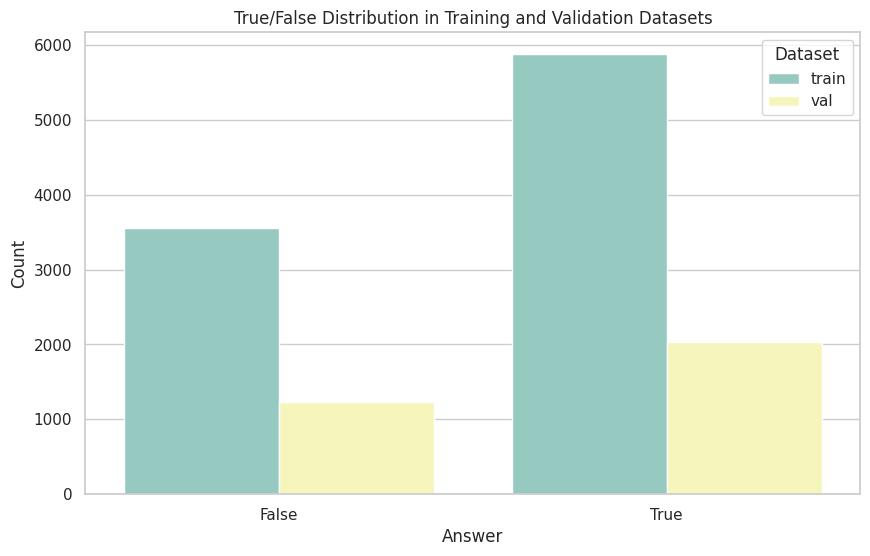

In [11]:
plt.figure(figsize=(10, 6))

sns.set(style="whitegrid")

sns.countplot(x='label', hue='split', data=combined_df, palette='Set3')
plt.title('True/False Distribution in Training and Validation Datasets')
plt.xlabel('Answer')
plt.ylabel('Count')
plt.legend(title='Dataset', loc="upper right")
plt.show()

<h5>Question length distribution</h5>

In [12]:
combined_df['q_len'] = combined_df.question.apply(lambda x: len(x.split()))
avg_q_len = int(combined_df.q_len.mean())
f"Average lenght of question: {avg_q_len}"

'Average lenght of question: 8'

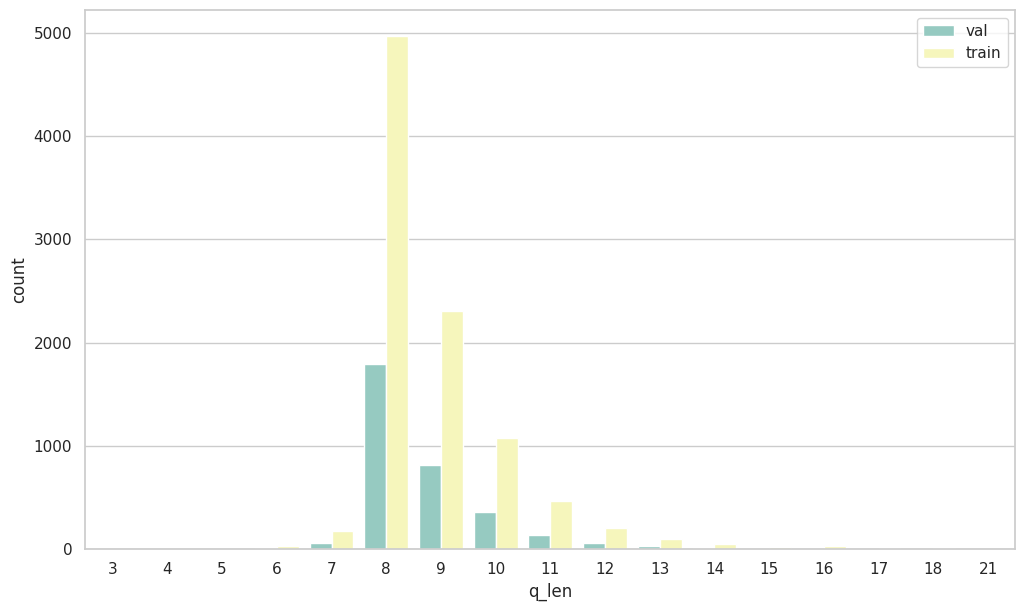

In [13]:
plt.figure(figsize=(12,7))
sns.countplot(x='q_len', hue='split', data=combined_df, palette='Set3')
plt.legend(loc="upper right")
plt.show()

<h5>Passage length distribution</h5>

In [14]:
train['pas_len'] = train.passage.apply(lambda x: len(x.split()))
val['pas_len'] = val.passage.apply(lambda x: len(x.split()))

avg_pas_len_train = int(train.pas_len.mean())
avg_pas_len_val = int(val.pas_len.mean())

print(f"Average lenght of train passage: {avg_pas_len_train}")
print(f"Average lenght of val passage: {avg_pas_len_val}")

Average lenght of train passage: 97
Average lenght of val passage: 96


Check both datasets for none/null:

In [15]:
print('train dataset ')
print(train.isnull().sum())
print('\nval dataset')
print(val.isnull().sum())

train dataset 
question    0
passage     0
label       0
split       0
pas_len     0
dtype: int64

val dataset
question    0
passage     0
label       0
split       0
pas_len     0
dtype: int64


From `True/False Distribution in Training and Validation Datasets` we can see that data is unbalanced. We can improve that:

In [16]:
train = train.groupby("label").sample(3553)

In [17]:
train['label'].value_counts()

False    3553
True     3553
Name: label, dtype: int64

In [18]:
train["text"] = train["question"] + " " + train["passage"]
val["text"] = val["question"] + " " + val["passage"]

### 2. Pretrained embeddings as features for classifier

Text Normalization (Lowercasing and Removing Punctuation)

In [19]:
def normalize_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub("\s+", " ", text)
    text = text.strip()

    tokens = word_tokenize(text)

    return tokens

In [20]:
train['question'] = train['question'].apply(normalize_text)
train['passage'] = train['passage'].apply(normalize_text)
val['question'] = val['question'].apply(normalize_text)
val['passage'] = val['passage'].apply(normalize_text)

In [21]:
from gensim.models import KeyedVectors

word_vectors = KeyedVectors.load_word2vec_format('/content/drive/MyDrive/Chat_bot/GoogleNews-vectors-negative300.bin', binary=True)

Vectorizing:

In [22]:
def vectorize_sentence(words, word_vectors):
    vectors = [word_vectors[word.lower()] for word in words if word.lower() in word_vectors]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(word_vectors.vector_size)


In [23]:
train['question_vector'] = train['question'].apply(lambda x: vectorize_sentence(x, word_vectors))
train['passage_vector'] = train['passage'].apply(lambda x: vectorize_sentence(x, word_vectors))

Concatenating vectors of questions and passages:

In [24]:
train['features'] = train.apply(lambda x: np.concatenate([x['question_vector'], x['passage_vector'],\
                                                          np.array([x['pas_len']])]), axis=1)

In [25]:
train.head(5)

,question,passage,label,split,pas_len,text,question_vector,passage_vector,features
4411,"[is, a, driving, licence, a, national, identit...","[list, of, national, identity, card, policies,...",False,train,60,is a driving licence a national identity card ...,"[0.03969116, 0.07524414, 0.13710937, -0.016577...","[-0.022591183, -0.015401499, 0.06551763, 0.064...","[0.03969116136431694, 0.07524414360523224, 0.1..."
5122,"[are, there, any, military, bases, in, san, fr...","[presidio, of, san, francisco, the, presidio, ...",False,train,56,are there any military bases in san francisco ...,"[0.008239746, 0.09938049, 0.10240173, 0.060729...","[0.021745397, 0.09052423, 0.061897766, 0.02775...","[0.00823974609375, 0.0993804931640625, 0.10240..."
728,"[has, there, ever, been, a, convention, of, st...","[convention, to, propose, amendments, to, the,...",False,train,90,has there ever been a convention of states Con...,"[0.028320312, -0.0013224283, 0.04520162, 0.111...","[-0.025733685, 0.027637083, 0.06677201, 0.1525...","[0.0283203125, -0.0013224283466115594, 0.04520..."
3681,"[is, it, illegal, to, jaywalk, in, the, uk]","[jaywalking, the, term, jaywalking, is, used, ...",False,train,129,is it illegal to jaywalk in the uk Jaywalking ...,"[0.044498987, -0.025964191, 0.09357561, 0.0321...","[0.053587314, 0.026085336, 0.071737126, 0.0855...","[0.0444989874958992, -0.025964191183447838, 0...."
6838,"[are, pasilla, chiles, and, poblano, chiles, t...","[pasilla, in, the, united, states, producers, ...",False,train,32,are pasilla chiles and poblano chiles the same...,"[-0.10065569, 0.039997645, 0.27322823, 0.22694...","[0.0023369421, 0.012110784, 0.050738994, 0.124...","[-0.1006556898355484, 0.0399976447224617, 0.27..."


In [26]:
val.head(5)

,question,passage,label,split,pas_len,text
0,"[does, ethanol, take, more, energy, make, that...","[ethanol, fuel, all, biomass, goes, through, a...",False,val,220,does ethanol take more energy make that produc...
1,"[is, house, tax, and, property, tax, are, same]","[property, tax, property, tax, or, house, tax,...",True,val,194,is house tax and property tax are same Propert...
2,"[is, pain, experienced, in, a, missing, body, ...","[phantom, pain, phantom, pain, sensations, are...",True,val,57,is pain experienced in a missing body part or ...
3,"[is, harry, potter, and, the, escape, from, gr...","[harry, potter, and, the, escape, from, gringo...",True,val,93,is harry potter and the escape from gringotts ...
4,"[is, there, a, difference, between, hydroxyzin...","[hydroxyzine, hydroxyzine, preparations, requi...",True,val,49,is there a difference between hydroxyzine hcl ...


In [27]:
val['question_vector'] = val['question'].apply(lambda x: vectorize_sentence(x, word_vectors))
val['passage_vector'] = val['passage'].apply(lambda x: vectorize_sentence(x, word_vectors))

In [28]:
val['features'] = val.apply(lambda x: np.concatenate([x['question_vector'], x['passage_vector'],\
                                                          np.array([x['pas_len']])]), axis=1)

In [29]:
X_train = np.vstack(train[train['split'] == 'train']['features'])
y_train = train[train['split'] == 'train']['label']
X_val = np.vstack(val[val['split'] == 'val']['features'])
y_val = val[val['split'] == 'val']['label']

In [30]:
print('x_train:', X_train.shape)
print('y_train:', y_train.shape)
print('x_val:', X_val.shape)
print('y_val:', y_val.shape)

x_train: (7106, 601)
y_train: (7106,)
x_val: (3270, 601)
y_val: (3270,)


In [31]:
X_train[0]

array([ 3.96911614e-02,  7.52441436e-02,  1.37109369e-01, -1.65771488e-02,
       -6.62109405e-02,  6.61254898e-02, -1.02539062e-02, -9.83886719e-02,
        1.85791012e-02, -4.85595688e-02,  1.98303219e-02, -7.73376450e-02,
       -5.73242195e-02, -6.54785186e-02, -4.51171882e-02,  4.21630852e-02,
        4.01733406e-02,  1.14453122e-01, -6.54296856e-03, -1.49462894e-01,
       -7.09960908e-02,  4.94628921e-02, -2.56835930e-02,  2.98339836e-02,
        4.72167954e-02,  2.10449211e-02, -1.15332030e-01,  1.26611322e-01,
        2.13818356e-01, -5.71289062e-02,  8.43750015e-02, -4.58984375e-02,
        1.27441406e-01,  2.32421868e-02,  1.08081058e-01, -2.73437495e-03,
        8.59375019e-03,  2.07519537e-04,  6.66992217e-02,  2.26562507e-02,
       -3.52172852e-02, -4.90234382e-02,  1.02416992e-01, -1.11328121e-02,
        4.52148430e-02, -1.18359372e-01,  2.85461433e-02,  1.11718751e-01,
        9.71496552e-02,  5.42480461e-02, -1.50732428e-01,  1.55566409e-01,
        4.51171882e-02, -

In [32]:
# Training a classifier SVM
classifier = SVC(kernel='linear')
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)

In [33]:
print(f"Validation Accuracy: {accuracy:.3f}")

Validation Accuracy: 0.602


Results almost the same for both models and quite poor, probably because of low quality of text vectorization. Let's check cross-validation if the validation accuracy is consistent across different subsets of data:

In [34]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

       False       0.48      0.61      0.54      1237
        True       0.72      0.60      0.65      2033

    accuracy                           0.60      3270
   macro avg       0.60      0.60      0.59      3270
weighted avg       0.63      0.60      0.61      3270



`Precision` is higher for 'True' than for 'False', but its `recall` suggests it misses a significant portion of both 'True' and 'False'. The relatively low F1-scores indicate the model could be improvement in terms of balancing `precision` and `recall`

Lets's implement Bert embeddings:

In [35]:
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")
bert_model = BertModel.from_pretrained("bert-base-multilingual-cased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [36]:
def get_bert_embs(data, tokenizer, model):
    embeddings = []
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for row in tqdm(data):
        row = ' '.join(row)
        model_input = tokenizer(row, return_tensors="pt", truncation=True, padding=True)
        model_input = {k: v.to(device) for k, v in model_input.items()}

        with torch.no_grad():
            model_output = model(**model_input)

        res = model_output.pooler_output.detach().cpu().numpy().flatten()
        embeddings.append(res)

    return np.array(embeddings)

In [37]:
train_bert_X_q = get_bert_embs(train["question"], bert_tokenizer, bert_model)
train_bert_X_p = get_bert_embs(train["passage"], bert_tokenizer, bert_model)

100%|██████████| 7106/7106 [01:37<00:00, 73.01it/s]


In [38]:
train_bert_X = np.concatenate((train_bert_X_q, train_bert_X_p), axis=1)
train_bert_X.shape

(7106, 1536)

In [39]:
val_bert_q = get_bert_embs(val["question"], bert_tokenizer, bert_model)
val_bert_p = get_bert_embs(val["passage"], bert_tokenizer, bert_model)

100%|██████████| 3270/3270 [00:46<00:00, 71.08it/s]


In [40]:
val_bert_comb = np.concatenate((val_bert_q, val_bert_p), axis=1)
val_bert_comb.shape

(3270, 1536)

In [41]:
classifier = SVC(kernel='linear')
classifier.fit(train_bert_X, y_train)

y_pred = classifier.predict(val_bert_comb)
accuracy = accuracy_score(y_val, y_pred)

In [42]:
print(f"Validation Accuracy: {accuracy:.3f}")

Validation Accuracy: 0.601


In [43]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

       False       0.48      0.60      0.53      1237
        True       0.71      0.60      0.65      2033

    accuracy                           0.60      3270
   macro avg       0.60      0.60      0.59      3270
weighted avg       0.62      0.60      0.61      3270



I've got result a little bit better than the privious one, but it's not dramatically

### 3. Fine-tune BERT

In [44]:
def normalize_text(texts):
    stemmer = PorterStemmer()

    normalized_texts = []
    for text in texts:
        text = text.lower()
        text = re.sub(f"[{string.punctuation}]", "", text)
        tokens = word_tokenize(text)
        stemmed_tokens = [stemmer.stem(token) for token in tokens]

        normalized_text = " ".join(stemmed_tokens)
        normalized_texts.append(normalized_text)
    return normalized_texts


In [45]:
train['text'] = normalize_text(train['text'].to_list())

In [46]:
bert_tokens = bert_tokenizer(train['text'].to_list(), padding=True, truncation=True, return_tensors="pt", max_length=128, add_special_tokens=True)

In [47]:
bert_dataset = TensorDataset(
    bert_tokens["input_ids"],
    bert_tokens["attention_mask"],
    torch.tensor(y_train.to_numpy(), dtype=torch.long)
)

In [48]:
bert_dataset_train, bert_dataset_eval = random_split(bert_dataset, [0.9, 0.1])

In [55]:
BATCH_SIZE = 10
bert_dataloader_train = DataLoader(bert_dataset_train,
                                   sampler=RandomSampler(bert_dataset_train),
                                   batch_size=BATCH_SIZE)
bert_dataloader_eval = DataLoader(bert_dataset_eval,
                                   sampler=SequentialSampler(bert_dataset_eval),
                                   batch_size=BATCH_SIZE)

In [56]:
device = torch.device("cuda")

bert_classifier = BertForSequenceClassification.from_pretrained(
                        "bert-base-multilingual-cased",
                        num_labels=2,
                        output_attentions=False,
                        output_hidden_states=False
                       )

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [57]:
bert_classifier.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [58]:
epochs = 10

optimizer = torch.optim.AdamW(bert_classifier.parameters(), lr=3e-5, eps=1e-8)

total_steps = len(bert_dataloader_train) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [59]:
def train_and_evaluate(epochs, bert_classifier, optimizer, scheduler, bert_dataloader_train, bert_dataloader_eval, device, accumulation_steps=4):
    torch.cuda.empty_cache()
    train_stats = []

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        bert_classifier.train()
        train_losses, eval_losses, eval_accuracies = [], [], []

        optimizer.zero_grad()

        for step, batch in enumerate(tqdm(bert_dataloader_train, desc="Training")):
            input_ids, attention_mask, labels = [b.to(device) for b in batch]

            with torch.cuda.amp.autocast():
                outputs = bert_classifier(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss / accumulation_steps

            loss.backward()

            if (step + 1) % accumulation_steps == 0 or (step + 1) == len(bert_dataloader_train):
                optimizer.step()
                scheduler.step()
                optimizer.zero_grad()

            train_losses.append(loss.item() * accumulation_steps)

        train_loss = np.mean(train_losses)
        print(f"Training loss: {train_loss}")

        bert_classifier.eval()

        for batch in tqdm(bert_dataloader_eval, desc="Evaluation"):
            input_ids, attention_mask, labels = [b.to(device) for b in batch]

            with torch.no_grad(), torch.cuda.amp.autocast():
                outputs = bert_classifier(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                eval_losses.append(loss.item())

                logits = outputs.logits.detach().cpu().numpy()
                label_ids = labels.detach().cpu().numpy()
                predictions = np.argmax(logits, axis=1)
                accuracy = accuracy_score(label_ids, predictions)
                eval_accuracies.append(accuracy)

        eval_loss = np.mean(eval_losses)
        eval_accuracy = np.mean(eval_accuracies)
        print(f"Evaluation loss: {eval_loss}, Accuracy: {eval_accuracy}")

        train_stats.append({
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "eval_loss": eval_loss,
            "accuracy": eval_accuracy,
        })

    return train_stats


In [60]:
train_and_evaluate(epochs=epochs, bert_classifier=bert_classifier, optimizer=optimizer, scheduler=scheduler, bert_dataloader_train=bert_dataloader_train, bert_dataloader_eval=bert_dataloader_eval, device=device)

Epoch 1/10


Training: 100%|██████████| 640/640 [00:40<00:00, 15.62it/s]


Training loss: 0.6912819107063115


Evaluation: 100%|██████████| 71/71 [00:01<00:00, 63.05it/s]


Evaluation loss: 0.6689277761419055, Accuracy: 0.5999999999999999
Epoch 2/10


Training: 100%|██████████| 640/640 [00:32<00:00, 19.67it/s]


Training loss: 0.6447381732985378


Evaluation: 100%|██████████| 71/71 [00:01<00:00, 61.40it/s]


Evaluation loss: 0.6716802884155596, Accuracy: 0.6366197183098592
Epoch 3/10


Training: 100%|██████████| 640/640 [00:33<00:00, 19.09it/s]


Training loss: 0.5517073781695216


Evaluation: 100%|██████████| 71/71 [00:01<00:00, 62.94it/s]


Evaluation loss: 0.696868553128041, Accuracy: 0.6492957746478873
Epoch 4/10


Training: 100%|██████████| 640/640 [00:33<00:00, 18.95it/s]


Training loss: 0.3988307928026188


Evaluation: 100%|██████████| 71/71 [00:01<00:00, 48.93it/s]


Evaluation loss: 0.811945226830496, Accuracy: 0.6464788732394366
Epoch 5/10


Training: 100%|██████████| 640/640 [00:32<00:00, 19.86it/s]


Training loss: 0.2482898426707834


Evaluation: 100%|██████████| 71/71 [00:01<00:00, 63.85it/s]


Evaluation loss: 0.8823358290632006, Accuracy: 0.6478873239436619
Epoch 6/10


Training: 100%|██████████| 640/640 [00:34<00:00, 18.73it/s]


Training loss: 0.1666237066150643


Evaluation: 100%|██████████| 71/71 [00:01<00:00, 64.02it/s]


Evaluation loss: 0.8984992816834383, Accuracy: 0.6816901408450705
Epoch 7/10


Training: 100%|██████████| 640/640 [01:03<00:00, 10.06it/s]


Training loss: 0.1211427499205456


Evaluation: 100%|██████████| 71/71 [00:01<00:00, 35.90it/s]


Evaluation loss: 1.0716162775184068, Accuracy: 0.6760563380281691
Epoch 8/10


Training: 100%|██████████| 640/640 [00:32<00:00, 19.59it/s]


Training loss: 0.08164349674789265


Evaluation: 100%|██████████| 71/71 [00:01<00:00, 61.72it/s]


Evaluation loss: 1.2236127401111832, Accuracy: 0.6802816901408452
Epoch 9/10


Training: 100%|██████████| 640/640 [00:38<00:00, 16.81it/s]


Training loss: 0.05083355176766417


Evaluation: 100%|██████████| 71/71 [00:01<00:00, 66.85it/s]


Evaluation loss: 1.4237847559049095, Accuracy: 0.6859154929577466
Epoch 10/10


Training: 100%|██████████| 640/640 [00:34<00:00, 18.81it/s]


Training loss: 0.03677165017124935


Evaluation: 100%|██████████| 71/71 [00:01<00:00, 64.53it/s]

Evaluation loss: 1.6603811163927469, Accuracy: 0.6647887323943662


[{'epoch': 1,
  'train_loss': 0.6912819107063115,
  'eval_loss': 0.6689277761419055,
  'accuracy': 0.5999999999999999},
 {'epoch': 2,
  'train_loss': 0.6447381732985378,
  'eval_loss': 0.6716802884155596,
  'accuracy': 0.6366197183098592},
 {'epoch': 3,
  'train_loss': 0.5517073781695216,
  'eval_loss': 0.696868553128041,
  'accuracy': 0.6492957746478873},
 {'epoch': 4,
  'train_loss': 0.3988307928026188,
  'eval_loss': 0.811945226830496,
  'accuracy': 0.6464788732394366},
 {'epoch': 5,
  'train_loss': 0.2482898426707834,
  'eval_loss': 0.8823358290632006,
  'accuracy': 0.6478873239436619},
 {'epoch': 6,
  'train_loss': 0.1666237066150643,
  'eval_loss': 0.8984992816834383,
  'accuracy': 0.6816901408450705},
 {'epoch': 7,
  'train_loss': 0.1211427499205456,
  'eval_loss': 1.0716162775184068,
  'accuracy': 0.6760563380281691},
 {'epoch': 8,
  'train_loss': 0.08164349674789265,
  'eval_loss': 1.2236127401111832,
  'accuracy': 0.6802816901408452},
 {'epoch': 9,
  'train_loss': 0.050833551

In [61]:
val['text'] = normalize_text(val['text'].to_list())

In [65]:
bert_tokens_valid = bert_tokenizer(val["text"].to_list(), padding=True, truncation=True, return_tensors="pt", max_length=128, add_special_tokens=True)

In [66]:
bert_dataset_valid = TensorDataset(
    bert_tokens_valid["input_ids"],
    bert_tokens_valid["attention_mask"],
    torch.tensor(y_val, dtype=torch.long)
)
bert_dataloader_valid = DataLoader(bert_dataset_valid,
                                   sampler=SequentialSampler(bert_dataset_valid),
                                   batch_size=BATCH_SIZE)


In [68]:
true_labels = []
predicted_labels = []
for batch in tqdm(bert_dataloader_valid):
    input_ids = batch[0].to(device)
    attention_mask = batch[1].to(device)
    labels = batch[2].to(device)

    with torch.no_grad():
        output = bert_classifier(input_ids, attention_mask, labels=labels)

    true_labels.extend(labels.detach().cpu().tolist())
    predictions = np.argmax(output.logits.detach().cpu().numpy(), axis=1).flatten().tolist()
    predicted_labels.extend(predictions)

print(f"Validation Accuracy: {accuracy_score(true_labels, predicted_labels):.3f}")

100%|██████████| 327/327 [00:09<00:00, 35.03it/s]

Validation Accuracy: 0.681


In [69]:
print(classification_report(true_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.56      0.70      0.62      1237
           1       0.78      0.67      0.72      2033

    accuracy                           0.68      3270
   macro avg       0.67      0.68      0.67      3270
weighted avg       0.70      0.68      0.69      3270



The fine-tuned BERT model achieves an accuracy of 68%. It performs better at identifying class 1 instances (precision of 0.78) but is more reliable at recalling class 0 instances (recall of 0.70). The F1-scores suggest a balanced performance between precision and recall across both classes

### Summary & Results Analysis

   - `Pre-trained Embeddings with SVM` (Word2Vec): this model achieved a validation accuracy of around 60.2%, with slightly better precision for the positive class (True) than the negative class (False). The recall indicates these models are somewhat better at identifying true positives for the negative class, but there's a balance in terms of precision and recall across classes.
   
   - `BERT Embeddings with SVM`: using BERT embeddings with an SVM classifier resulted in a similar accuracy to the pre-trained embeddings at 60.1%. The precision, recall, and F1-scores are closely aligned with the results from the Word2Vec model, indicating that simply using BERT embeddings with SVM does not significantly outperform traditional embeddings in this setup.
   
   - `Fine-tuned BERT`: this approach got a higher validation accuracy of 68.1%, demonstrating an improvement over embedding-based models. The increase in precision for the positive class and recall for the negative class suggests that fine-tuning BERT leads to a more balanced performance across classes, effectively capturing the nuances of the dataset.



###  Improvements

1. Increasing the size and diversity of the training set can help improve model generalization.

2. Fine-tuning the hyperparameters of model, including learning rates, batch sizes, and regularization terms, can optimize performance.

3. Combining the predictions from multiple models through ensemble techniques could improve the strengths of model and improve overall accuracy.